In [6]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input,  GlobalAveragePooling2D, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
from tensorflow.keras.utils import Sequence
import pandas as pd
import numpy as np
import os

In [7]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPUs available:")
    for gpu in gpus:
        print(gpu)
    print("\nTensorFlow is using the following GPU(s):")
    print(tf.config.experimental.get_visible_devices('GPU'))
else:
    print("No GPUs found. TensorFlow is running on CPU.")

GPUs available:
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')

TensorFlow is using the following GPU(s):
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [8]:
!nvidia-smi

Wed Nov 13 15:30:06 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.27                 Driver Version: 560.70         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4050 ...    On  |   00000000:01:00.0 Off |                  N/A |
| N/A   48C    P0             11W /   95W |       0MiB /   6141MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [12]:
class MultiLabelGenerator(Sequence):
    def __init__(self, dataframe, directory, batch_size, img_size, num_classes, datagen):
        self.dataframe = dataframe
        self.directory = directory
        self.batch_size = batch_size
        self.img_size = img_size
        self.num_classes = num_classes
        self.datagen = datagen
        self.indices = np.arange(len(self.dataframe))
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.dataframe) / self.batch_size))

    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_images = []
        batch_labels = []

        for i in batch_indices:
            filename = self.dataframe.iloc[i]['filename']
            labels = self.dataframe.iloc[i]['labels'].split(',')

            # Load image and resize
            img_path = os.path.join(self.directory, filename)
            img = load_img(img_path, target_size=self.img_size)
            img = img_to_array(img) / 255.0  # Rescale image

            # One-hot encode labels
            label = np.zeros(self.num_classes)
            for fruit in labels:
                class_index = class_indices[fruit]
                label[class_index] = 1.0

            batch_images.append(img)
            batch_labels.append(label)

        batch_images = np.array(batch_images)
        batch_labels = np.array(batch_labels)

        # Apply data augmentation if defined
        batch_images = np.array([self.datagen.random_transform(img) for img in batch_images])
        return batch_images, batch_labels

    def on_epoch_end(self):
        np.random.shuffle(self.indices)

In [ ]:
train_dir = "/mnt/c/Capstone Project/Model/Database/Kulkas/Train"
val_dir = "/mnt/c/Capstone Project/Model/Database/Kulkas/CV"
test_dir = "/mnt/c/Capstone Project/Model/Database/Kulkas/Test"

class_names = sorted(os.listdir(train_dir))
class_indices = {class_name: index for index, class_name in enumerate(class_names)}
num_classes = len(class_indices)

print("Class indices:", class_indices)
print("Number of classes:", num_classes)

train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_datagen = ImageDataGenerator(
    rescale=1.0/255.0
)

test_datagen = ImageDataGenerator(
    rescale=1.0/255.0
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(256, 256),
    batch_size=64,
    class_mode='categorical',
    shuffle = True
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(256, 256),
    batch_size=64,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(256, 256),
    batch_size=64,
    class_mode='categorical'
)

Class indices: {'apple': 0, 'apricot': 1, 'avocado': 2, 'bacon': 3, 'bagel': 4, 'banana': 5, 'beans': 6, 'beef': 7, 'beet': 8, 'blackberries': 9, 'bread': 10, 'broccoli': 11, 'butter': 12, 'cabbage': 13, 'carrot': 14, 'cauliflower': 15, 'celery': 16, 'cheese': 17, 'cherries': 18, 'chicken': 19, 'chocolate': 20, 'coconut': 21, 'corn': 22, 'crab': 23, 'cranberries': 24, 'cucumber': 25, 'daikon': 26, 'dates': 27, 'eggs': 28, 'fish': 29, 'garlic': 30, 'grape': 31, 'green_bell_pepper': 32, 'ham': 33, 'honey': 34, 'kiwi': 35, 'lemon': 36, 'lettuce': 37, 'lime': 38, 'mango': 39, 'melon': 40, 'milk': 41, 'mushroom': 42, 'nectarine': 43, 'onion': 44, 'pear': 45, 'peking': 46, 'pepper': 47, 'plum': 48, 'pomegranate': 49, 'pomelo': 50, 'potato': 51, 'pumpkin': 52, 'raddish': 53, 'raspberries': 54, 'red_bell_pepper': 55, 'rhubarb': 56, 'rice': 57, 'sausage': 58, 'shallot': 59, 'spinach': 60, 'sweetpotato': 61, 'tangerine': 62, 'tofu': 63, 'tomato': 64, 'watermelon': 65, 'yellow_bell_pepper': 66, '

In [14]:
if tf.config.list_physical_devices('GPU'):
    print ("Pakai GPU")
else:
    print("Pake CPU")

Pakai GPU


In [6]:
model = tf.keras.models.load_model('/mnt/c/Capstone Project/Deployed/Test.h5')

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=4,
)

I0000 00:00:1731471131.277187     472 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3539 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9
/home/nicholas_tanugroho/miniconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/home/nicholas_tanugroho/miniconda3/lib/python3.12/site-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/4


I0000 00:00:1731471137.234553     616 service.cc:148] XLA service 0x7feef4004340 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731471137.234860     616 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4050 Laptop GPU, Compute Capability 8.9
2024-11-13 11:12:17.281855: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1731471137.442574     616 cuda_dnn.cc:529] Loaded cuDNN version 90300
2024-11-13 11:12:18.381621: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1104', 16 bytes spill stores, 16 bytes spill loads

2024-11-13 11:12:18.743192: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1104

1623/2240 ━━━━━━━━━━━━━━━━━━━━ 11:08 1s/step - accuracy: 0.6307 - loss: 1.8608

2024-11-13 11:41:27.587413: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1104', 20 bytes spill stores, 20 bytes spill loads

2024-11-13 11:41:28.448413: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1104', 1740 bytes spill stores, 1208 bytes spill loads

2024-11-13 11:41:28.692976: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1311', 152 bytes spill stores, 152 bytes spill loads

2024-11-13 11:41:28.759407: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1311', 48 bytes spill stores, 48 bytes spill loads

2024-11-13 11:41:28.954327: I external/local_xla/xla/s

2222/2240 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.6309 - loss: 1.8635

/home/nicholas_tanugroho/miniconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-11-13 11:52:24.115434: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_121', 136 bytes spill stores, 136 bytes spill loads

2024-11-13 11:52:48.426762: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng20{k2=2,k4=0,k5=0,k6=0,k7=0,k19=0} for conv (f32[64,64,60,60]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,64,62,62]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForwar

2240/2240 ━━━━━━━━━━━━━━━━━━━━ 2708s 1s/step - accuracy: 0.6309 - loss: 1.8636 - val_accuracy: 0.6719 - val_loss: 1.8691
Epoch 2/4
2240/2240 ━━━━━━━━━━━━━━━━━━━━ 2661s 1s/step - accuracy: 0.6392 - loss: 1.8511 - val_accuracy: 0.6618 - val_loss: 1.9503
Epoch 3/4
2240/2240 ━━━━━━━━━━━━━━━━━━━━ 2611s 1s/step - accuracy: 0.6417 - loss: 1.8461 - val_accuracy: 0.6701 - val_loss: 1.9276
Epoch 4/4
2240/2240 ━━━━━━━━━━━━━━━━━━━━ 2514s 1s/step - accuracy: 0.6495 - loss: 1.8339 - val_accuracy: 0.6585 - val_loss: 1.9752


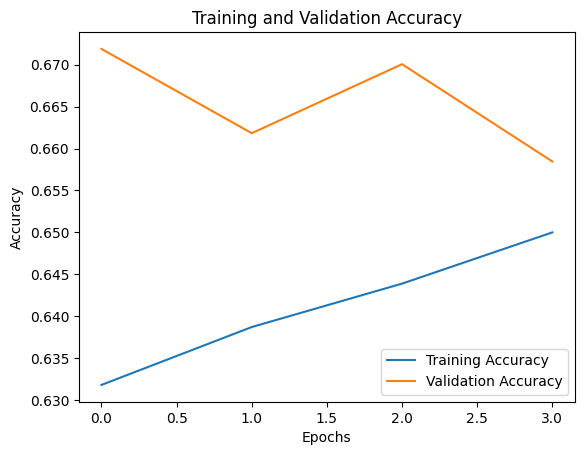

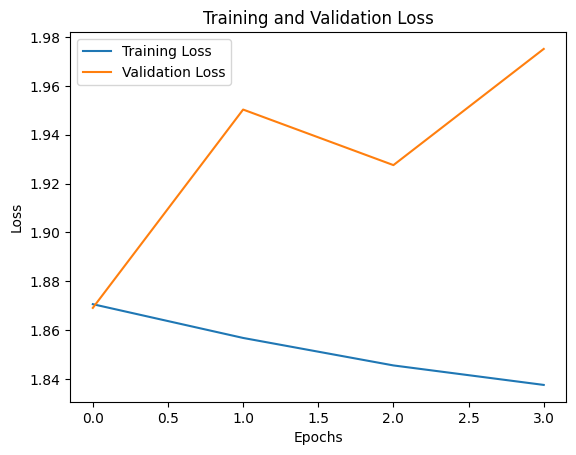

In [7]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [9]:
val_loss, val_acc = model.evaluate(val_generator)
tra_loss, tra_acc = model.evaluate(train_generator)
test_loss, test_acc = model.evaluate(test_generator)

print(f"Train Accuracy\t\t: {tra_acc * 100:.2f}% | Train Loss\t\t: {tra_loss}")
print(f"Validation Accuracy\t: {val_acc * 100:.2f}% | Validation Loss\t: {val_loss}")
print(f"Test Accuracy\t\t: {test_acc * 100:.2f}% | Test Loss\t\t: {test_loss}")

 23/413 ━━━━━━━━━━━━━━━━━━━━ 4:31 696ms/step - accuracy: 0.6636 - loss: 1.9854

/home/nicholas_tanugroho/miniconda3/lib/python3.12/site-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


413/413 ━━━━━━━━━━━━━━━━━━━━ 270s 652ms/step - accuracy: 0.6593 - loss: 1.9709
2239/2240 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7440 - loss: 1.5584 

2024-11-13 15:04:45.269780: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_121', 240 bytes spill stores, 240 bytes spill loads



2240/2240 ━━━━━━━━━━━━━━━━━━━━ 2467s 1s/step - accuracy: 0.7440 - loss: 1.5584


/home/nicholas_tanugroho/miniconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


509/520 ━━━━━━━━━━━━━━━━━━━━ 8s 788ms/step - accuracy: 0.6190 - loss: 2.8903

2024-11-13 15:11:16.448443: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_121', 8 bytes spill stores, 8 bytes spill loads



520/520 ━━━━━━━━━━━━━━━━━━━━ 388s 746ms/step - accuracy: 0.6189 - loss: 2.8911
Train Accuracy		: 74.41% | Train Loss		: 1.5567426681518555
Validation Accuracy	: 65.85% | Validation Loss	: 1.9751522541046143
Test Accuracy		: 61.74% | Test Loss		: 2.9192893505096436


In [10]:
model.save(r"../Deployed/food_recognition_model_BLMOPT_("+str(test_acc*100)+"%).h5")